In [51]:
import pandas as pd
import numpy as np
import seaborn as sns

In [94]:
dtype1={'year_ID':str, 'ID':str, 'TrueDate':str, 'AnDate':str, 'DeltaTime':float, 'ISSameStudy':str,
       'MinDxDate':str, 'MaxDxDate':str, 'ToDX':float, 'Man':str, 'MedCtr':str, 'Study':str, 'Rows':float,
       'Spacing':float, 'KV':float, 'KV_SD':float, 'MA':float, 'MA_SD':float, 'Exp':float, 'Exp_SD':float, 'B_TKN':float,
       'B_TKN_SD':float, 'Force':float, 'Force_SD':float, 'Report_correct':str, 'Translated_report':str,
       'Conclusion':str, 'Conclusion.1':str, 'Age':str, 'BI-RADS':str, 'Breast_density':str,
       'Family_risk':str, 'Biopsy_suggested':str, 'Implants':str, 'Cancer_history':str,
       'Prev surgery/biopsy':str, 'Unnamed: 36':str, 'Unnamed: 37':str}
data = pd.read_csv("ReportsFINAL2014_2019.csv",dtype=dtype1)
data_exp=data[['year_ID','ID','Study','Rows','Spacing', 'KV', 'KV_SD', 'MA', 'MA_SD', 'Exp', 'Exp_SD', 'B_TKN',
       'B_TKN_SD', 'Age', 'BI-RADS', 'Breast_density', 'Family_risk', 'Biopsy_suggested', 'Implants', 'Cancer_history',
       'Prev surgery/biopsy', 'AnDate','MinDxDate','MaxDxDate','ToDX']]
data_exp.dtypes

year_ID                 object
ID                      object
Study                   object
Rows                   float64
Spacing                float64
KV                     float64
KV_SD                  float64
MA                     float64
MA_SD                  float64
Exp                    float64
Exp_SD                 float64
B_TKN                  float64
B_TKN_SD               float64
Age                     object
BI-RADS                 object
Breast_density          object
Family_risk             object
Biopsy_suggested        object
Implants                object
Cancer_history          object
Prev surgery/biopsy     object
AnDate                  object
MinDxDate               object
MaxDxDate               object
ToDX                   float64
dtype: object

In [95]:
data_exp.set_index('ID')
data_exp.head()

,year_ID,ID,Study,Rows,Spacing,KV,KV_SD,MA,MA_SD,Exp,...,Breast_density,Family_risk,Biopsy_suggested,Implants,Cancer_history,Prev surgery/biopsy,AnDate,MinDxDate,MaxDxDate,ToDX
0,2014_S0000001,S0000001,Standard Screening - Combo,3328.0,0.065238,30.500000,1.000000,120.0,0.000000,1129.750000,...,2,0,0,0,0,0,20140101,NaN,NaN,NaN
1,2014_S0000003,S0000003,Implant Screening - Conventional,3328.0,0.059968,28.100000,1.728840,88.0,25.298221,996.200000,...,4,0,0,1,0,0,20140101,NaN,NaN,NaN
2,2014_S0000009,S0000009,Standard Screening - Combo,3328.0,0.065238,30.000000,0.000000,100.0,0.000000,1021.500000,...,3,1,0,0,0,0,20140101,NaN,NaN,NaN
3,2014_S0000014,S0000014,Standard Screening - Conventional,3328.0,0.065238,28.777778,1.201850,100.0,0.000000,869.444444,...,3,0,0,1,0,1,20140101,NaN,NaN,NaN
4,2014_S0000029,S0000029,Standard Screening - Combo,3328.0,0.065238,30.400000,0.894427,172.0,4.472136,1384.800000,...,3,0,0,0,0,0,20140101,NaN,NaN,NaN


In [96]:
#research gate / https://www.researchgate.net/post/How_to_calculate_X_ray_dose_using_mAs_and_kV_without_using_any_detector
# D = g * kV^2 * mA * s / d
# g constant (tungsten) = 1
exp=data_exp["KV"]**2*data_exp["MA"]*data_exp["Exp"]/data_exp["B_TKN"]
data_exp.insert(1,"exp_m1",exp)
data_exp.insert(1,"miu_rho_tissue",0)

<Axes: xlabel='Breast_density', ylabel='Count'>

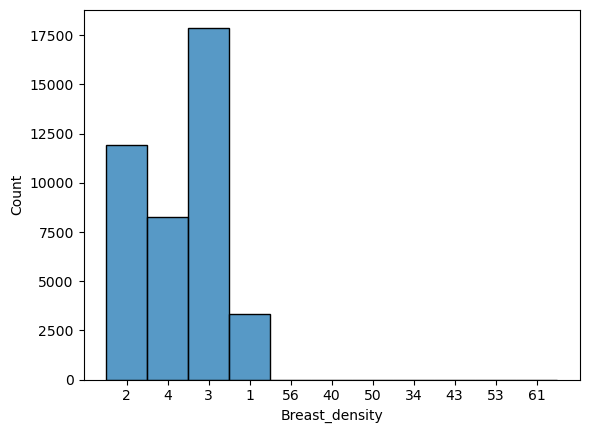

In [97]:
# rho tissue - https://physics.nist.gov/PhysRefData/XrayMassCoef/tab4.html
for index, val in enumerate(data_exp["Breast_density"]):
    if val == "1":
        data_exp.loc[index,"miu_rho_tissue"]=118.8
    elif val == "2" or val=="3":
        data_exp.loc[index,"miu_rho_tissue"]=(118.8+154.6)/2
    else:
        data_exp.loc[index,"miu_rho_tissue"]=154.6

sns.histplot(data_exp['Breast_density'])

In [98]:
# u of t - 4.2.1 / https://www.physics.utoronto.ca/~key/PHY138/Suppl.Notes/Worked%20Examples.pdf
# Then Energy In = A Ψ(0) ; Energy Out = A Ψ(0) exp(– µen L) ; Energy deposited = A Ψ(0){1 - exp(– µenL)}
# If density of tissue is ρ, then mass of patient irradiated is ALρ
# So Average Dose = Dav = A Ψ(0){ 1 - exp(– µenL)}/ALρ = Ψ(0){ 1 - exp(– µenL)}/Lρ (N.B. A cancels)
# Ψ = 8.69 · 10-3 X / (µen/ρ)air , with X = 1.3 R 

exp=data_exp["MA"]*data_exp["Exp"]*(1-np.exp(data_exp["miu_rho_tissue"]*data_exp["B_TKN"]*-1))
data_exp.insert(1,"exp_m2",exp)

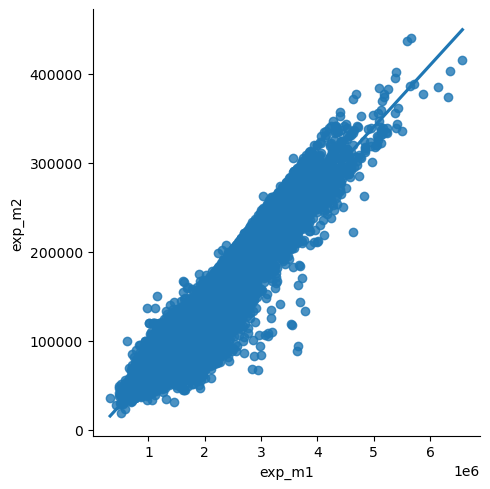

In [99]:
sns.lmplot(data=data_exp, x="exp_m1", y="exp_m2")

<Axes: xlabel='exp_m1', ylabel='exp_m2'>

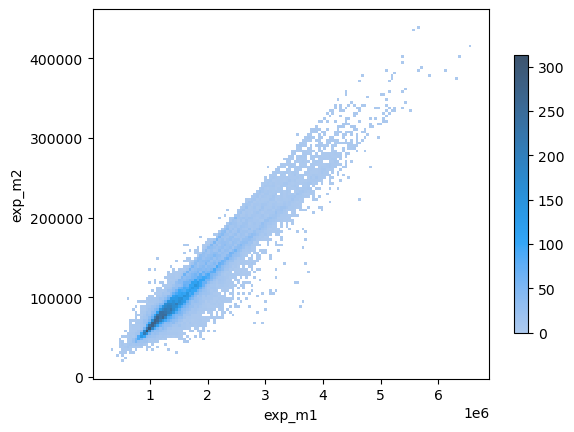

In [100]:
sns.histplot(
    data_exp, x="exp_m1", y="exp_m2",
    cbar=True, cbar_kws=dict(shrink=.75),
)

In [101]:
data_exp["Study"].unique()

array(['Standard Screening - Combo', 'Implant Screening - Conventional',
       'Standard Screening - Conventional', 'CMZH-UCIDM MAMOGRAFIA',
       'Unilateral Mammography, Left', 'Combo Unilateral Right MLO',
       'Combo Unilateral Left', 'UCIDM MAMOGRAFIA', 'Ductography, Left',
       'Needle Localization, Right', 'Combo Unilateral Right CC',
       'Implant Screening - Combo', 'Combo Unilateral Left MLO',
       'Screening Mammography w/Implants', 'Combo Unilateral Left CC',
       'Needle Localization, Left', 'Combo Unilateral Right',
       'Unilateral Mammography, Right', 'Screening-Bilateral Mammography',
       'SCREENING', 'All Views', 'gdcm::Unfound',
       'INONC-UCIDM MAMOGRAFIA', 'UCIDM ESTEROTAXIA',
       'HSJ21-UCIDM MAMOGRAFIA', 'Standard Screening - ComboHD',
       'Standard Screening - TomoHD', 'TomoHD Unilateral Right',
       'ComboHD Needle Localization, Left', 'Standard Screening - Tomo',
       'ComboHD Unilateral Right', 'ComboHD Unilateral Right CC',
    

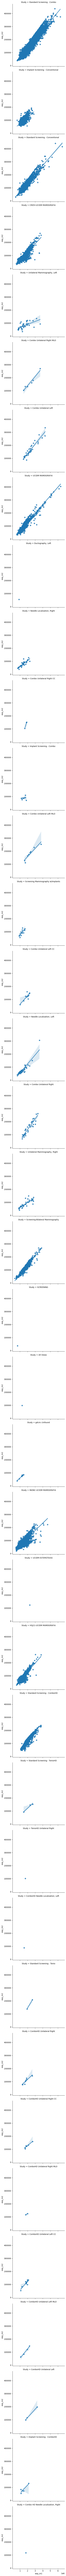

In [102]:
#relacion por tipo de estudio
sns.lmplot(data=data_exp, x="exp_m1", y="exp_m2", row="Study")

In [107]:
#cancer futuro, cancer pasado
#data_exp.insert(1,"DxCancer",0)
cancerfuturo=data_exp[data_exp['ToDX']<-365]['exp_m1']
sincancer=data_exp[data_exp['ToDX'].isna()]['exp_m1']


In [108]:
cancerfuturo.describe()

count    3.180000e+02
mean     1.864532e+06
std      7.290747e+05
min      6.645423e+05
25%      1.350164e+06
50%      1.721037e+06
75%      2.218043e+06
max      4.591132e+06
Name: exp_m1, dtype: float64

In [109]:
sincancer.describe()

count    4.000300e+04
mean     1.717494e+06
std      6.621712e+05
min      3.193863e+05
25%      1.235975e+06
50%      1.567119e+06
75%      2.037484e+06
max      6.573281e+06
Name: exp_m1, dtype: float64

In [110]:
(cancerfuturo.mean()-sincancer.mean())/cancerfuturo.std()

0.20167733551702235

In [111]:
classCancer
sns.metrics.plot_roc_curve(cancerfuturo, sincancer)

AttributeError: module 'seaborn' has no attribute 'metrics'